In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import re
import pandas as pd

from skimage import exposure, feature, transform
from skimage.color import rgb2gray

# classification required packages
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib

# %matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# import PIL.Image


In [2]:
root = pathlib.Path('../data/orl_faces/')
dirlist = pathlib.os.listdir(root)

In [3]:
rootpath = '../data/orl_faces/'
def get_csvfiles(rootpath):
    import re
    csvfiles = []
    root = pathlib.Path(rootpath)
    dirlist = pathlib.os.listdir(root)
    dirs = sorted([x for x in dirlist if re.search(r"^s", x)])
    for i, name in enumerate(dirs):
        for root1, dirs1, files1 in pathlib.os.walk(pathlib.os.path.join(root, name)):
            csvfile = ([pathlib.os.path.join(root, name,x) for x in files1 if re.search(r"^FR", x)])
            csvfiles.append(csvfile[0])
    return csvfiles

In [4]:
def training_data(csvfiles):
    images = []
    labels = []
    for csvfile in csvfiles:
        csvpath = csvfile
        dirpath = '/'.join(csvpath.split('/')[:-1])
        df1 = pd.read_csv(csvpath)
        for im_index in range(0,len(df1)):
            im_path = '/'.join([dirpath,df1.iloc[im_index,0]])
            img = plt.imread(im_path)
            images.append(img)

            lbl = df1.iloc[im_index,1]
            labels.append(lbl)
    return images, labels

In [5]:
csvfiles = get_csvfiles(rootpath)
X, y = training_data(csvfiles)

In [6]:
def showimg_n_hog(grayimg,hogImage):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box-forced')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box-forced')
    plt.show()

In [20]:
if os.path.isfile("../data/features/HoGfeatures.npy") & os.path.isfile("../data/features/HoGvisualize.npy") :
    print("loading from file ... ")
    hogfeat = np.load("../data/features/HoGfeatures.npy")
    hogviz = np.load("../data/features/HoGvisualize.npy")
    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
else:
    print("HoGfeatures.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0,len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 100 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        grayim = rgb2gray(I)

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(8,8),
        cells_per_block=(2,2),block_norm = 'L2-Hys', transform_sqrt=True, visualise=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
#         hogImage = hogImage.astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("../data/features/HoGfeatures.npy", Hfeat)
    np.save("../data/features/HoGvisualize.npy", Hviz)
    print("HoGfeatures.npy are saved")  
    print("HoGvisualize.npy are saved")

HoGfeatures.npy does not found
[INFO] processed 100/400
[INFO] processed 200/400
[INFO] processed 300/400
HoGfeatures.npy are saved
HoGvisualize.npy are saved


In [21]:
Xhog = np.array(hogfeat).astype("float")
print(Xhog.shape,len(y))
print(np.unique(y))

(400, 4680) 400
['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5' 's6'
 's7' 's8' 's9']


In [22]:
features = Xhog
labels = y

# take the  data and construct the training and testing split, using 75% of the
# data for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(features,
    labels, test_size=0.25, random_state=42)
 
# now, let's take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels,
    test_size=0.1, random_state=84)
 
# show the sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

training data points: 270
validation data points: 30
testing data points: 100


In [23]:
# svm
if os.path.isfile("../data/clf/clf_svc_hog.pkl"):
    print("[INFO] loading classifier: SVC trained on HoG features...")
    svc = joblib.load("../data/clf/clf_svc_hog.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    svc = LinearSVC()
    svc.fit(trainData,trainLabels)
#     scores = cross_val_score(svc,testData,testLabels)
#     svc.fit(trainData,trainLabels)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(svc, '../data/clf/clf_svc_hog.pkl') 
    print("[INFO] Classifier Saved")


[INFO] pre-trained classifier not found. 
 Training Classifier SVC
[INFO] Succefully trained the classsifier. 
 Saving the classifier for further use
[INFO] Classifier Saved


In [24]:
print("accuracy on training data: {}".format(svc.score(trainData,trainLabels)))

print("accuracy on test data: {}".format(svc.score(testData,testLabels)))

print("accuracy on validation data: {}".format(svc.score(valData,valLabels)))

accuracy on training data: 1.0
accuracy on test data: 0.95
accuracy on validation data: 0.9666666666666667


In [25]:
predictions = svc.predict(testData)
 
# show a final classification report demonstrating the accuracy of the classifier
print("EVALUATION ON TESTING DATA")
print(classification_report(testLabels, predictions))

EVALUATION ON TESTING DATA
             precision    recall  f1-score   support

         s1       1.00      1.00      1.00         4
        s10       1.00      0.50      0.67         2
        s11       0.67      1.00      0.80         2
        s12       0.80      1.00      0.89         4
        s13       1.00      1.00      1.00         3
        s14       1.00      1.00      1.00         3
        s15       1.00      1.00      1.00         1
        s16       1.00      0.86      0.92         7
        s17       1.00      1.00      1.00         2
        s18       1.00      1.00      1.00         3
        s19       1.00      1.00      1.00         3
         s2       1.00      1.00      1.00         4
        s20       1.00      1.00      1.00         2
        s21       1.00      1.00      1.00         1
        s22       1.00      1.00      1.00         3
        s23       1.00      1.00      1.00         2
        s25       0.75      1.00      0.86         3
        s26       

In [35]:
def testing_on_data():
    n = np.random.randint(0, high=len(testLabels))
    test1 =X[n]
    t1_true = y[n]
    
    fig = plt.figure()
    fig.suptitle('Face recognition', fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    ax.set_title('Person')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    grayim = rgb2gray(test1)
    (t1_feat, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(8,8),
        cells_per_block=(2,2),block_norm='L2-Hys', transform_sqrt=True, visualise=True)
    t1_feat = t1_feat.reshape(1, -1)
    t1_predict = svc.predict(t1_feat)
    print("==========")
    print("True :{}\npredicted:{}\n".format(t1_true,t1_predict[0]))
    # show the prediction
    print("I think this person belongs to class: {}".format(t1_predict[0]))
    print("==========")
    
    ax.set_xlabel('True Class: {}'.format(t1_true))
    ax.set_ylabel('Predicted Class: {}'.format(t1_predict[0]))
    mytext = '{}-{}'.format(t1_true,t1_predict[0])
    if (t1_true==t1_predict[0]):
        ax.text(5, 9.12,mytext, style='italic',bbox={'facecolor':'green', 'alpha':1, 'pad':10}, fontweight='bold')
    else:
        ax.text(5, 9.12, mytext, style='italic',bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
    ax.imshow(test1,cmap='gray')
    plt.show()

True :s17
predicted:s17

I think this person belongs to class: s17


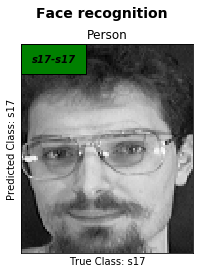

True :s15
predicted:s15

I think this person belongs to class: s15


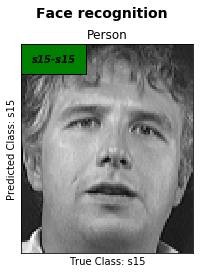

True :s16
predicted:s16

I think this person belongs to class: s16


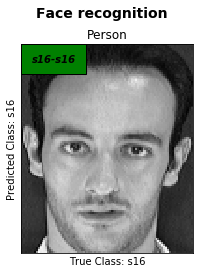

True :s14
predicted:s14

I think this person belongs to class: s14


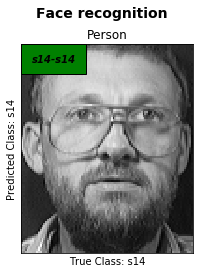

True :s13
predicted:s13

I think this person belongs to class: s13


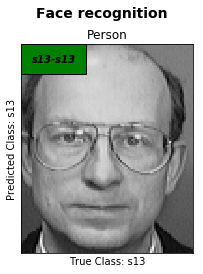

True :s1
predicted:s1

I think this person belongs to class: s1


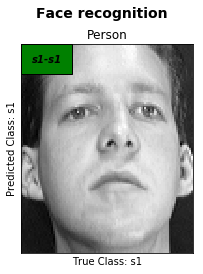

True :s17
predicted:s17

I think this person belongs to class: s17


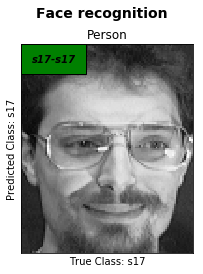

True :s15
predicted:s15

I think this person belongs to class: s15


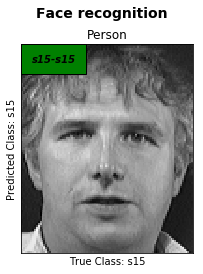

True :s10
predicted:s10

I think this person belongs to class: s10


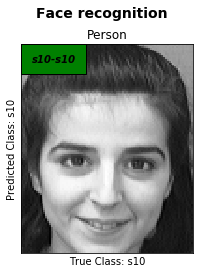

True :s15
predicted:s15

I think this person belongs to class: s15


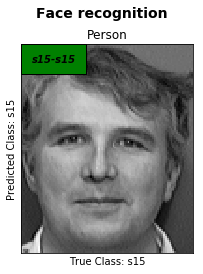

In [36]:
for i in range(10):
    testing_on_data()